In [372]:
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.tokenize import regexp_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import defaultdict
import re, nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.patches as mpatches
import random
from sklearn import metrics
import re
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag, corpus
from sklearn.preprocessing import MinMaxScaler

In [199]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Packag

True

In [200]:
#UMICH SI650 - Sentiment Classification
#https://www.kaggle.com/competitions/si650winter11/data

In [201]:
!pip install vaderSentiment

In [202]:
! pip install -q kaggle
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [203]:
#Choose the kaggle.json file that you downloaded
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [231]:
! kaggle competitions download -c si650winter11
! unzip si650winter11.zip -d si650winter11

si650winter11.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  si650winter11.zip
replace si650winter11/testdata.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [232]:
#Read test and train datasets
# header=0 -> first line contains column names
# delimiter=\t -> fields are separated by tabs
# quoting=3 -> ignore double quotes

train_data_df  = pd.read_table('si650winter11/training.txt', names=['sentiment', 'comment'], header=None, delimiter="\t", quoting=3)
test_data_df  = pd.read_table('si650winter11/testdata.txt', names=['comment'], header=None, delimiter="\t", quoting=3)

In [233]:
test_data_df.head(5)

,comment
0,""" I don't care what anyone says, I like Hillar..."
1,have an awesome time at purdue!..
2,"Yep, I'm still in London, which is pretty awes..."
3,"Have to say, I hate Paris Hilton's behavior bu..."
4,i will love the lakers.


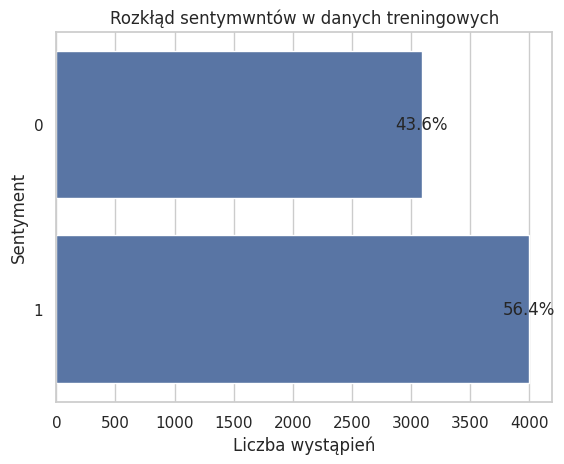

In [234]:
ax = sns.countplot(y="sentiment", data=train_data_df)
ax.set(title="Rozkłąd sentymwntów w danych treningowych", xlabel="Liczba wystąpień", ylabel="Sentyment")
total_freq = len(train_data_df)
for p in ax.patches:
    percentage = f'{100 * p.get_width() / total_freq:.1f}%'
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

In [235]:
#number words per sentence
np.mean([len(s.split(" ")) for s in train_data_df.comment])

10.886819079875812

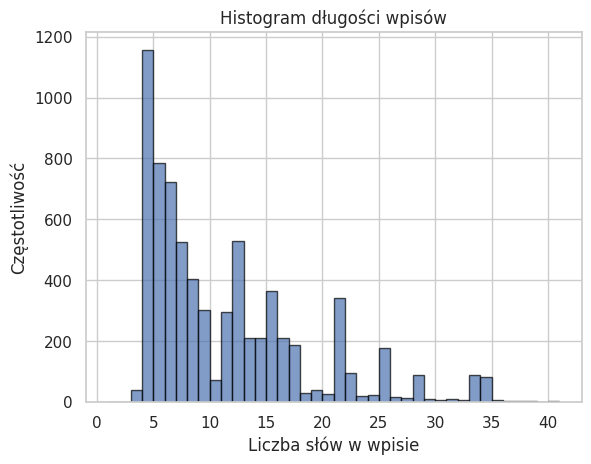

In [236]:
#Make a frequency list of lengths of tokenized each sentences
list_freq = [len(regexp_tokenize(s, "\w+")) for s in train_data_df["comment"]]

# Plot a histogram of the line lengths
#plt.figure(figsize=(8, 6))  # Ustawienie rozmiaru figury
plt.hist(list_freq, bins=range(1, max(list_freq) + 2), edgecolor='black', alpha=0.7)
plt.title("Histogram długości wpisów")
plt.xlabel("Liczba słów w wpisie")
plt.ylabel("Częstotliwość")
plt.show()

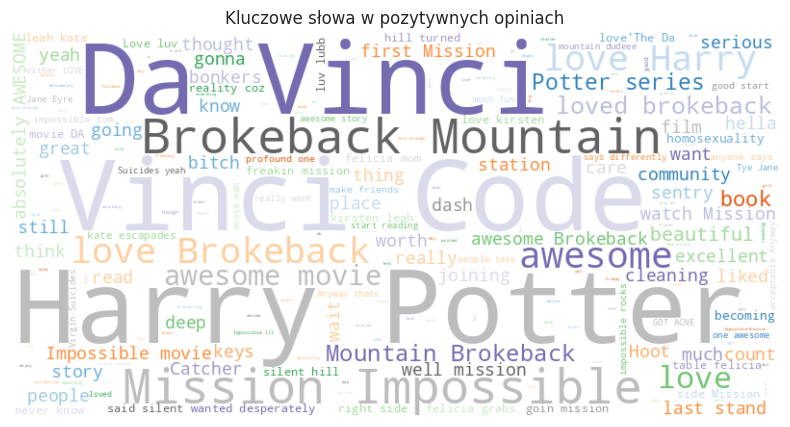

In [237]:
positive_comments = train_data_df[train_data_df['sentiment']==1]['comment']
text = " ".join(review for review in positive_comments)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20c').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Kluczowe słowa w pozytywnych opiniach")
plt.axis('off')
plt.show()

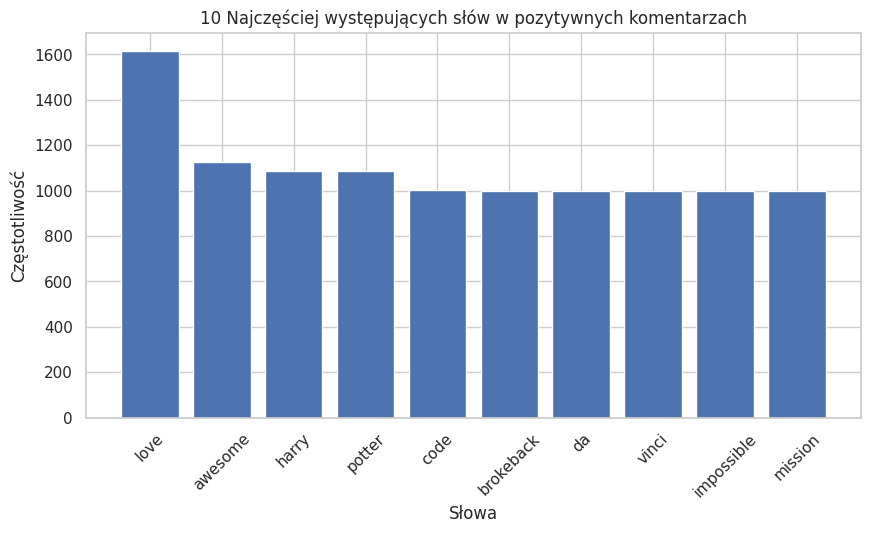

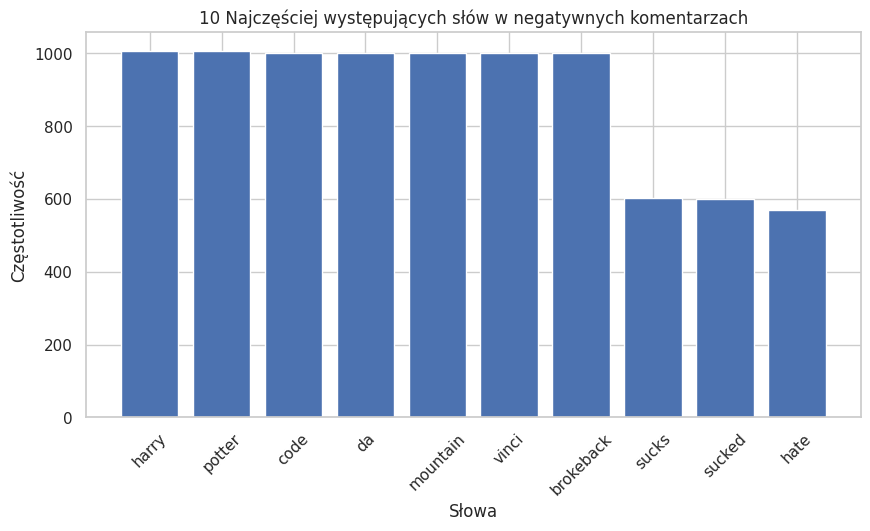

In [238]:
vectorizer = CountVectorizer(stop_words='english')

positive_comments = train_data_df[train_data_df['sentiment'] == 1]['comment']
positive_matrix = vectorizer.fit_transform(positive_comments)
positive_freq = zip(vectorizer.get_feature_names_out(), positive_matrix.sum(axis=0).tolist()[0])
positive_freq = sorted(positive_freq, key=lambda x: -x[1])

negative_comments = train_data_df[train_data_df['sentiment'] == 0]['comment']
negative_matrix = vectorizer.fit_transform(negative_comments)
negative_freq = zip(vectorizer.get_feature_names_out(), negative_matrix.sum(axis=0).tolist()[0])
negative_freq = sorted(negative_freq, key=lambda x: -x[1])

#Create histogram for top frequent words in positive comments
labels_pos, values_pos = zip(*positive_freq[:10])
plt.figure(figsize=(10,5))
plt.bar(labels_pos, values_pos)
plt.title('10 Najczęściej występujących słów w pozytywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()
#Create histogram for top frequent words in negative comments
labels_neg, values_neg = zip(*negative_freq[:10])
plt.figure(figsize=(10,5))
plt.bar(labels_neg, values_neg)
plt.title('10 Najczęściej występujących słów w negatywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()

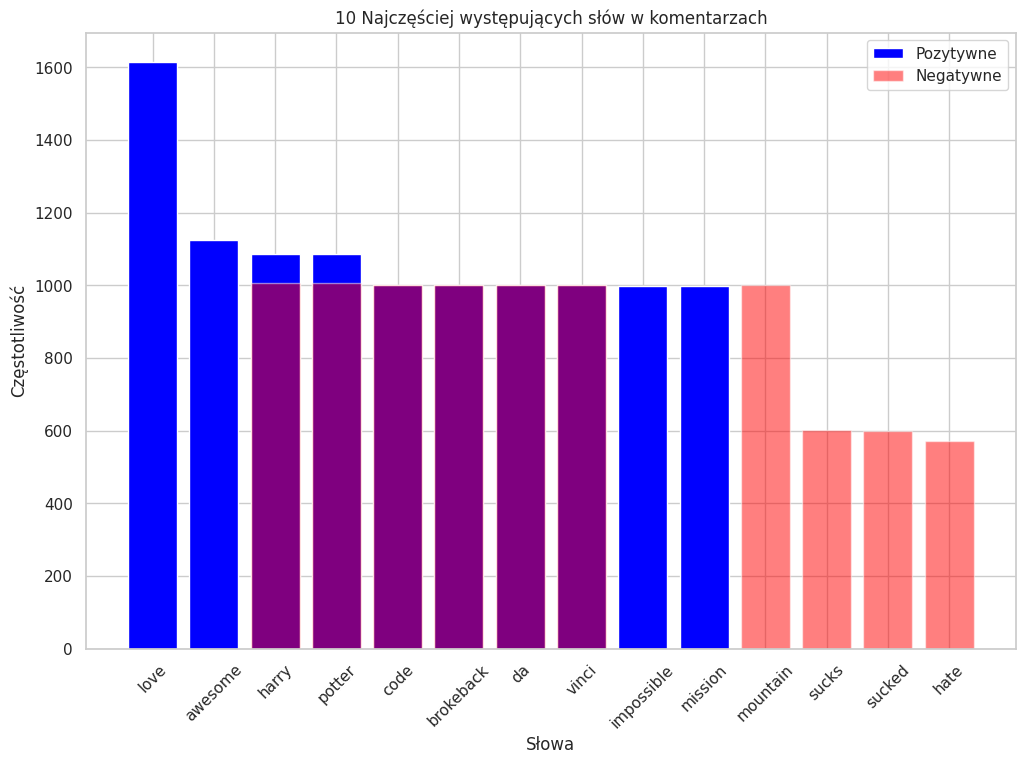

In [239]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(labels_pos, values_pos, color='blue', label='Pozytywne')
ax.bar(labels_neg, values_neg, color='red', label='Negatywne', alpha=0.5)
ax.set_title('10 Najczęściej występujących słów w komentarzach')
ax.set_ylabel('Częstotliwość')
ax.set_xlabel('Słowa')
ax.legend()
plt.xticks(rotation=45)
plt.show()

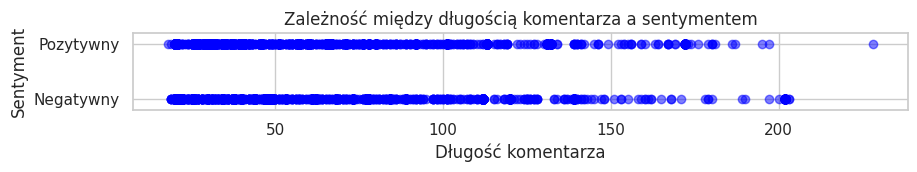

In [240]:
plt.figure(figsize=(10, 1))
plt.scatter(train_data_df['comment'].apply(len), train_data_df['sentiment'], color='blue', alpha=0.5)  # Ustawienie przezroczystości dla lepszej widoczności przy nakładaniu się punktów
plt.title('Zależność między długością komentarza a sentymentem')
plt.xlabel('Długość komentarza')
plt.ylabel('Sentyment')
plt.yticks([0, 1], ["Negatywny", "Pozytywny"])
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.show()

In [241]:
defaultdict(list)

defaultdict(list, {})

In [242]:
#Dictionary to store sentiment lists for every word
sentiment_dict = defaultdict(list)

rows = []
for _, row in train_data_df.iterrows():
    words = row['comment'].lower().split()
    for word in words:
        sentiment_dict[word].append(row['sentiment'])

def determine_color(sentiments):
    if all(s == 1 for s in sentiments):
        return 'green'
    elif all(s == 0 for s in sentiments):
        return 'red'
    else:
        return 'orange'

color_dict = {word: determine_color(sentiments) for word, sentiments in sentiment_dict.items()}

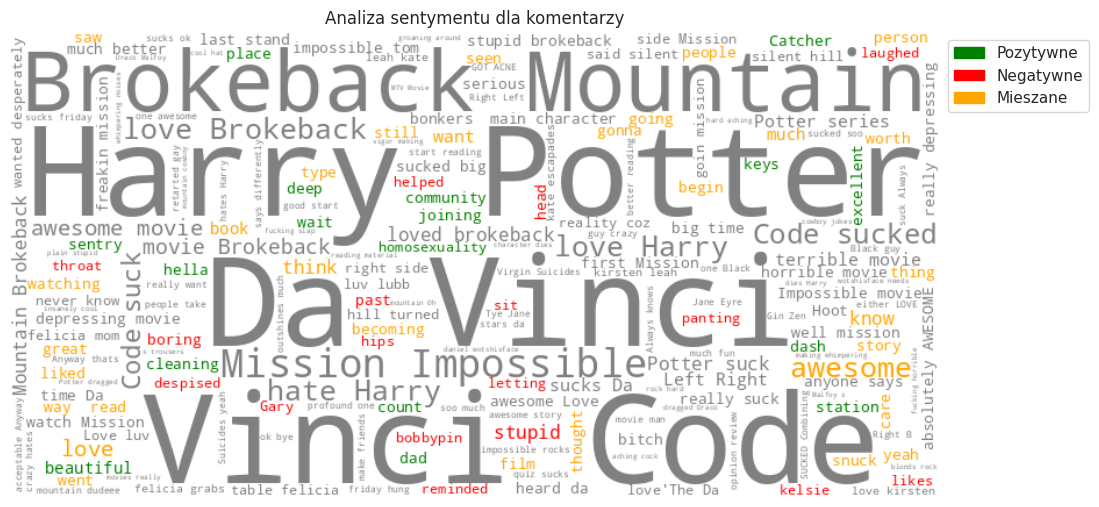

In [243]:
#Function color_func use color dictionary
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return color_dict.get(word.lower(), 'grey')

text = ' '.join(train_data_df['comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(text)
legend_elements = [
    mpatches.Patch(color='green', label='Pozytywne'),
    mpatches.Patch(color='red', label='Negatywne'),
    mpatches.Patch(color='orange', label='Mieszane')
]
plt.figure(figsize=(12, 7))
#plt.subplot(121)  # Użyj subplot, aby zrobić miejsce na legendę
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Analiza sentymentu dla komentarzy')
plt.axis('off')
plt.show()


In [244]:
#Preprocessing

In [245]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [246]:
def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text) #remove non letters
    tokens = nltk.word_tokenize(text) #tokenize
    stems = stem_tokens(tokens, PorterStemmer()) #stem
    return stems

In [247]:
count_vect = CountVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100)
#fits the model, model learns the vocabulary and transforms corpus data into feature vectors
comment_tf = count_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
#to numpy
comment_tf_nd = comment_tf.toarray()
comment_tf_nd.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

(40138, 100)

In [248]:
print("Comments term frequency (CountVectorize): ")
pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out()).head(5)

Comments term frequency (CountVectorize): 


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [249]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100, smooth_idf=False)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
comment_tfidf_nd.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

(40138, 100)

In [250]:
print("Comments term frequency-inverse document frequency (tf-idf):")
pd.DataFrame(comment_tfidf_nd, columns=tfidf_vect.get_feature_names_out()).head(5)

Comments term frequency-inverse document frequency (tf-idf):


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0.0,0.0,0.0,0.0,0.391895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.442319,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.384584,0.310759,0.272596,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.421334,0.000000,0.0,0.0,0.0,0.0,0.0


In [251]:
#words in vocabulary
vocab = count_vect.get_feature_names_out()
print(vocab)

['aaa' 'airlin' 'amaz' 'angelina' 'awesom' 'beauti' 'becaus' 'big'
 'boston' 'brokeback' 'car' 'citi' 'clinton' 'code' 'cool' 'crappi'
 'cruis' 'd' 'da' 'doe' 'don' 'drive' 'francisco' 'friend' 'fuck' 'fun'
 'geico' 'god' 'good' 'got' 'great' 'guy' 'ha' 'harri' 'harvard' 'hate'
 'hi' 'hilton' 'honda' 'imposs' 'joli' 'just' 'know' 'laker' 'left' 'like'
 'littl' 'london' 'look' 'lot' 'love' 'm' 'macbook' 'make' 'miss'
 'mission' 'mit' 'mountain' 'movi' 'na' 'need' 'new' 'oh' 'onli' 'pari'
 'peopl' 'person' 'potter' 'pretti' 'purdu' 'realli' 'right' 'rock' 's'
 'said' 'san' 'say' 'school' 'seattl' 'shanghai' 'shitti' 'stori' 'stupid'
 'suck' 't' 'thi' 'thing' 'think' 'time' 'tom' 'toyota' 'ucla' 've'
 'vinci' 'wa' 'want' 'way' 'whi' 'work' 'world']


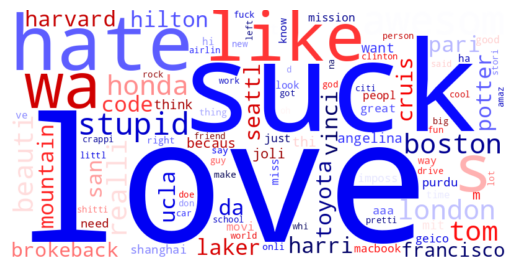

In [375]:
sum_vocab = np.sum(comment_tf_nd, axis=0)
word_frequencies = dict(zip(vocab, sum_vocab))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='seismic',).generate_from_frequencies(word_frequencies)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [471]:
# find some good and bad words
df = pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out())
selected_words = ['awesom', 'good', 'great', 'like', 'shitti', 'stupid', 'suck']
sum_data = dict()
for word in selected_words:
    sum_data[word] = df[word].sum()
#sum_data
df_subset = df[selected_words]
X_train, X_test, y_train, y_test  = train_test_split(df_subset[0:len(train_data_df)], train_data_df.sentiment,
                                                     train_size=0.75, random_state=1,
                                                     stratify=train_data_df.sentiment)

# Create and train the Logistic Regression Classifier
log_sw_model = LogisticRegression()
log_sw_model = log_sw_model.fit(X=X_train, y=y_train)

y_pred = log_sw_model.predict(X=X_test)
y_pred_prob_sw = log_sw_model.predict_proba(X=X_test)[:,1]
fpr_sw, tpr_sw, thresholds = metrics.roc_curve(y_test, y_pred_prob_sw)
roc_auc_sw = metrics.auc(fpr_sw, tpr_sw)

In [472]:
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
model_metrics = {}
model_metrics_temp = {}
#     }
def add_model_metrics(model_name, y_test, y_pred, y_probs, dict_name = "final"):

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_probs)
    pr_auc = metrics.auc(recall, precision)

    if dict_name == "final":
      model_metrics[model_name] = {
        'y_pred' : y_pred,
        'y_probs' : y_probs,
        'auc': metrics.roc_auc_score(y_test, y_probs),
        'precision': metrics.precision_score(y_test, y_pred),
        'recall': metrics.recall_score(y_test, y_pred),
        'f1_score': metrics.f1_score(y_test, y_pred),
        'roc_auc': metrics.roc_auc_score(y_test, y_pred),
        'pr_auc': pr_auc,
        'log_loss': metrics.log_loss(y_test, y_probs)
      }
    if dict_name == "selection":
      model_metrics_temp[model_name] = {
          'y_pred' : y_pred,
          'y_probs' : y_probs,
          'auc': metrics.roc_auc_score(y_test, y_probs),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1_score': metrics.f1_score(y_test, y_pred),
          'roc_auc': metrics.roc_auc_score(y_test, y_pred),
          'pr_auc': pr_auc,
          'log_loss': metrics.log_loss(y_test, y_probs)
          }

In [576]:
def calculate_weighted_score(model_measures):

    # Define weights corresponding to the order of metrics
    weights = np.array([
        0.4,  # AUC
        0.1,  # Precision
        0.1,  # Recall
        0.2,  # F1 Score
    ])

    # Convert list to numpy array if it's not already
    if not isinstance(model_measures, np.ndarray):
        model_measures = np.array(model_measures)

    # Calculate scores by weighted sum
    score = np.dot(model_measures, weights)
    print("final:", score)

    return score

In [577]:
def select_best_model():
    best_model = None
    best_score = -float('inf')  # Initialize to negative infinity
    data = []  # Prepare a list to collect all data dictionaries

    for model_name, model_measures in model_metrics_temp.items():

        # Extract scalar metrics from the dictionary and create a list for easier manipulation
        keys_of_interest = ['auc', 'precision', 'recall', 'f1_score']
        selected_metrics = [model_measures[key] for key in keys_of_interest if key in model_measures]

        # Calculate the score using weighted sum of the selected metrics
        score = calculate_weighted_score(selected_metrics)

        # Check if this model has a higher mean score
        if score > best_score:
            best_score = score
            best_model = model_name

        # Collect metrics data in a list
        data.append({
            'Model Name': model_name,
            'AUC': model_measures['auc'],
            'Precision': model_measures['precision'],
            'Recall': model_measures['recall'],
            'F1 Score': model_measures['f1_score'],
            'ROC AUC': model_measures['roc_auc'],
            'PR AUC': model_measures['pr_auc']
        })

    # Create DataFrame from the collected data
    metrics_df = pd.DataFrame(data)

    # Display all model metrics in a table
    if not metrics_df.empty:
        print("All Models' Metrics:")
        print(metrics_df.to_string(index=False))

    if best_model:
        # Transfer the best model data to the final dictionary
        model_metrics[best_model] = model_metrics_temp[best_model]
        # Clear temporary dictionary
        model_metrics_temp.clear()

        # Print best model details
        print(f"\nSelected best model: {best_model}")
        print("Metrics:")
        best_metrics = model_metrics[best_model]
        for key, value in best_metrics.items():
            if key != 'y_pred' and key != 'y_probs':
                print(f"{key}: {value:.4f}")
        print("This model has been saved to the final model_metrics dictionary.")


In [578]:
add_model_metrics('log_sw', y_test, y_pred, y_pred_prob_sw, "selection")

In [579]:
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(comment_tfidf_nd[0:len(train_data_df)],
                                                                             train_data_df.sentiment,
                                                                             train_size=0.75,
                                                                             random_state=1,
                                                                             stratify=train_data_df.sentiment)

log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train_tfidf, y=y_train_tfidf)
# classifier to label an evaluation set
y_pred_tfidf = log_tfidf_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = log_tfidf_model.predict_proba(X=X_test_tfidf)[:,1]

print(metrics.classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       773
           1       0.98      0.99      0.99       999

    accuracy                           0.98      1772
   macro avg       0.98      0.98      0.98      1772
weighted avg       0.98      0.98      0.98      1772



In [580]:
fpr_tfidf, tpr_tfidf, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
roc_auc_tfidf

0.9984350456536742

In [581]:
add_model_metrics('log_tfidf', y_test_tfidf, y_pred_tfidf, y_pred_prob_tfidf, "selection")

In [582]:
#tf linear classifier
# train and validation set split
X_train_tf, X_test_tf, y_train_tf, y_test_tf  = train_test_split(comment_tf_nd[0:len(train_data_df)],
                                                                 train_data_df.sentiment,
                                                                 train_size=0.75,
                                                                 random_state=1,
                                                                 stratify=train_data_df.sentiment)

log_tf_model = LogisticRegression()
log_tf_model = log_tf_model.fit(X=X_train_tf, y=y_train_tf)

# classifier to label an evaluation set
y_pred_tf = log_tf_model.predict(X=X_test_tf)
y_pred_prob_tf = log_tf_model.predict_proba(X=X_test_tf)[:,1]

print(metrics.classification_report(y_test_tf, y_pred_tf))
fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test_tf, y_pred_prob_tf)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)
roc_auc_tf

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       773
           1       0.99      0.99      0.99       999

    accuracy                           0.99      1772
   macro avg       0.99      0.99      0.99      1772
weighted avg       0.99      0.99      0.99      1772



0.9978814519564843

In [583]:
add_model_metrics('log_tf', y_test_tf, y_pred_tf, y_pred_prob_tf, "selection")

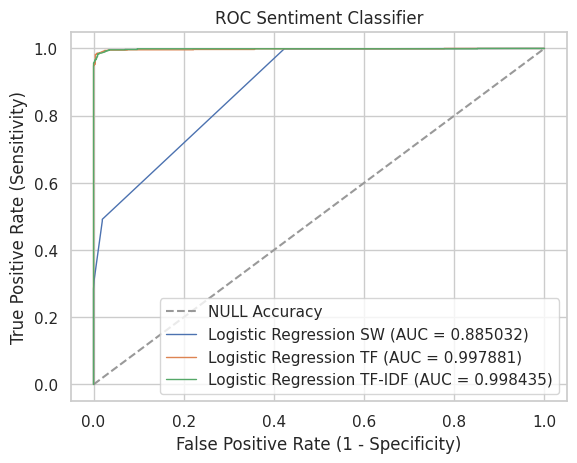

In [584]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [585]:
comment_tfidf_nd[0:len(train_data_df)]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [586]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100, smooth_idf=True)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
comment_tfidf_nd.shape
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf  = train_test_split(comment_tfidf_nd[0:len(train_data_df)], train_data_df.sentiment, train_size=0.75, random_state=1, stratify=train_data_df.sentiment)

# Logistic Regression Classifier
log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train_tfidf, y=y_train_tfidf)
# classifier to label an evaluation set
y_pred_tfidf = log_tfidf_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = log_tfidf_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_smooth, tpr_tfidf_smooth, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf_smooth = metrics.auc(fpr_tfidf_smooth, tpr_tfidf_smooth)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

In [587]:
add_model_metrics('log_tfidf_smooth', y_test_tfidf, y_pred_tfidf, y_pred_prob_tfidf, "selection")

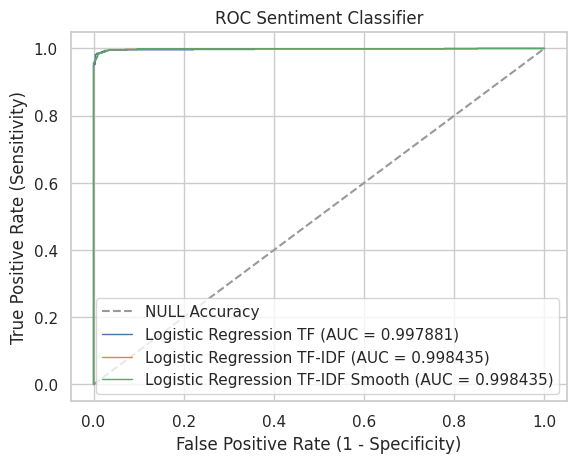

In [588]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

**Select the best Logistic Regression model** </br>
**Calculate the mean of the metrics for each model and finds the model with the best (highest) score**



In [589]:
#Choose the best model
select_best_model()

final: 0.727449349440433
final: 0.7010062050817439
final: 0.7935908846670493
final: 0.7941613002606351
final: 0.7935908846670493
All Models' Metrics:
             Model Name      AUC  Precision   Recall  F1 Score  ROC AUC   PR AUC
VADER_SentimentAnalysis 0.938975   0.814552 0.949937  0.877051 0.835208 0.939983
                 log_sw 0.885032   0.753208 0.998999  0.858864 0.787986 0.926377
              log_tfidf 0.998435   0.982107 0.988989  0.985536 0.982852 0.999064
                 log_tf 0.997881   0.985060 0.989990  0.987519 0.985293 0.998731
       log_tfidf_smooth 0.998435   0.982107 0.988989  0.985536 0.982852 0.999064

Selected best model: log_tf
Metrics:
auc: 0.9979
precision: 0.9851
recall: 0.9900
f1_score: 0.9875
roc_auc: 0.9853
pr_auc: 0.9987
log_loss: 0.0452
This model has been saved to the final model_metrics dictionary.


In [574]:
# sia = SentimentIntensityAnalyzer()

# train_data_df['vader_score'] = train_data_df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
# fpr_vader, tpr_vader, thresholds_vader = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_score'])
# roc_auc_vader = auc(fpr_vader, tpr_vader)

In [575]:
sia = SentimentIntensityAnalyzer()

train_data_df['vader_score'] = train_data_df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
train_data_df['vader_pred'] = train_data_df['vader_score'].apply(lambda x: 1 if x >= 0 else 0)


fpr_vader, tpr_vader, thresholds_vader = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_score'])
roc_auc_vader = metrics.auc(fpr_vader, tpr_vader)
print(roc_auc_vader)

add_model_metrics('VADER_SentimentAnalysis',
                  train_data_df['sentiment'],
                  train_data_df['vader_pred'],
                  train_data_df['vader_score'],
                  "selection")

0.9389753610648056


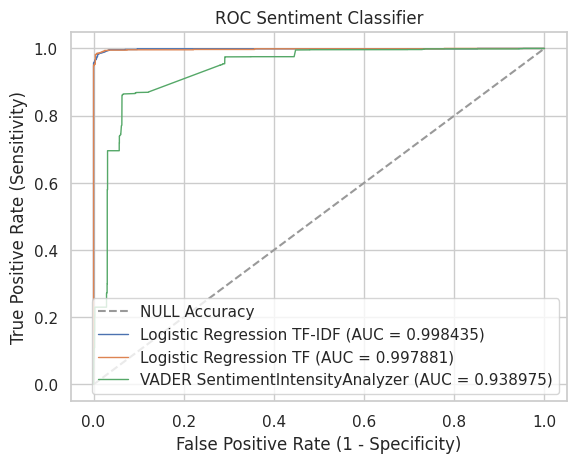

In [335]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [336]:
#Lemmatization with VADER
#Lemmatize the entire text without dividing it into sentences -> This simplifies the process, but may not take into account some of the linguistic nuances that arise from sentence structure.
#Lemmatization without specifying the part of speech

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])

In [337]:
train_data_df['lemmatized_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['vader_lemma_score'] = train_data_df['lemmatized_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
train_data_df['vader_lemma_pred'] = train_data_df['vader_lemma_score'].apply(lambda x: 1 if x >= 0 else 0)
fpr_lemmatizer, tpr_lemmatizer, thresholds = roc_curve(train_data_df['sentiment'], train_data_df['vader_lemma_score'])
roc_auc_lemmatizer = metrics.auc(fpr_lemmatizer, tpr_lemmatizer)
print(roc_auc_lemmatizer)

add_model_metrics('VADER_Lemma',
                  train_data_df['sentiment'],
                  train_data_df['vader_lemma_pred'],
                  train_data_df['vader_lemma_score'],
                  "selection")

0.9505137244914278


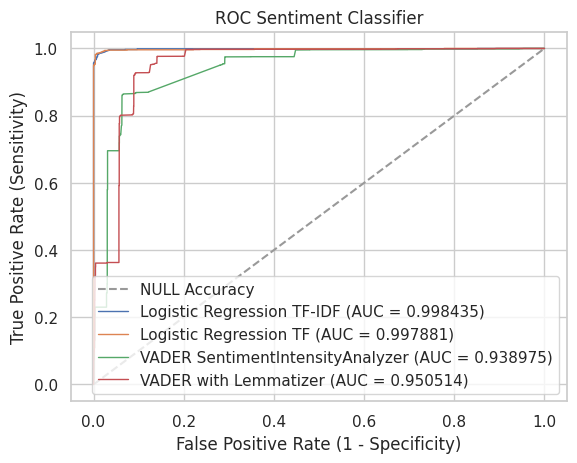

In [338]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [339]:
#Definition of the lemmatization function divided into sentences
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)
    lemmatized_output = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word) for word in words])
        lemmatized_output.append(lemmatized_sentence)

    return ' '.join(lemmatized_output)

In [340]:
from nltk.tokenize import sent_tokenize, word_tokenize
train_data_df['lemmatized_div_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['vader_lemma_div_score'] = train_data_df['lemmatized_div_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
train_data_df['vader_lemma_div_pred'] = train_data_df['vader_lemma_div_score'].apply(lambda x: 1 if x >= 0 else 0)
fpr_lem_div, tpr_lem_div, thresholds = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_lemma_div_score'])
roc_auc_lem_div = metrics.auc(fpr_lem_div, tpr_lem_div)

add_model_metrics('VADER_Lemma_Div',
                  train_data_df['sentiment'],
                  train_data_df['vader_lemma_div_pred'],
                  train_data_df['vader_lemma_div_score'],
                  "selection")

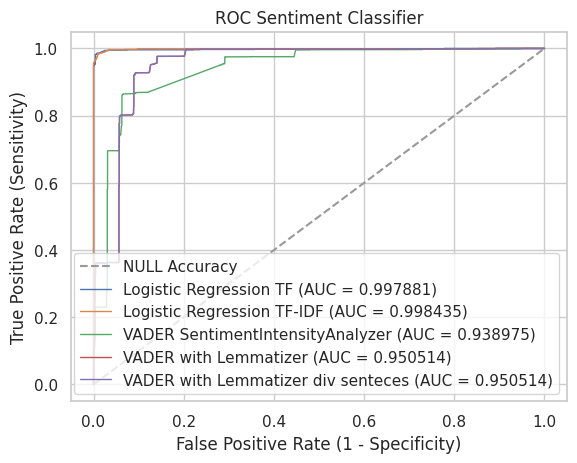

In [341]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [342]:
# from nltk import pos_tag

# def get_wordnet_pos(word):
#     """Mapowanie tagu POS do pierwszego znaku, który rozumie lemmatizer WordNet."""
#     tag = pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": nltk.corpus.wordnet.ADJ,
#                 "N": nltk.corpus.wordnet.NOUN,
#                 "V": nltk.corpus.wordnet.VERB,
#                 "R": nltk.corpus.wordnet.ADV}

#     return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

# def lemmatize_text(text):
#     lemmatizer = WordNetLemmatizer()
#     word_tokens = word_tokenize(text)
#     lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokens])
#     return lemmatized_output


In [343]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(word):
    """Map NLTK POS tag to a format recognized by WordNetLemmatizer"""
    tag = pos_tag([word])[0][1][0].upper()  # Get the first character of the POS tag
    tag_dict = {
        "J": corpus.wordnet.ADJ,
        "N": corpus.wordnet.NOUN,
        "V": corpus.wordnet.VERB,
        "R": corpus.wordnet.ADV
    }
    return tag_dict.get(tag, corpus.wordnet.NOUN)  # Default to noun if no match

# Function to lemmatize text with proper POS tagging
def lemmatize_text(text):
    """Lemmatize text with POS tag mapping for better accuracy"""
    sentences = sent_tokenize(text)
    lemmatized_text = []

    # Process each sentence
    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words])
        lemmatized_text.append(lemmatized_sentence)

    return ' '.join(lemmatized_text)


In [344]:
train_data_df['lemmatized2_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['lemma2__score'] = train_data_df['lemmatized2_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
train_data_df['vader_lemma2_pred'] = train_data_df['lemma2__score'].apply(lambda x: 1 if x >= 0 else 0)
fpr_lem2, tpr_lem2, thresholds = metrics.roc_curve(train_data_df['sentiment'], train_data_df['lemma2__score'])
roc_auc_lem2 = metrics.auc(fpr_lem2, tpr_lem2)

add_model_metrics('VADER_Lemma_Div',
                  train_data_df['sentiment'],
                  train_data_df['vader_lemma2_pred'],
                  train_data_df['lemma2__score'],
                  "selection")

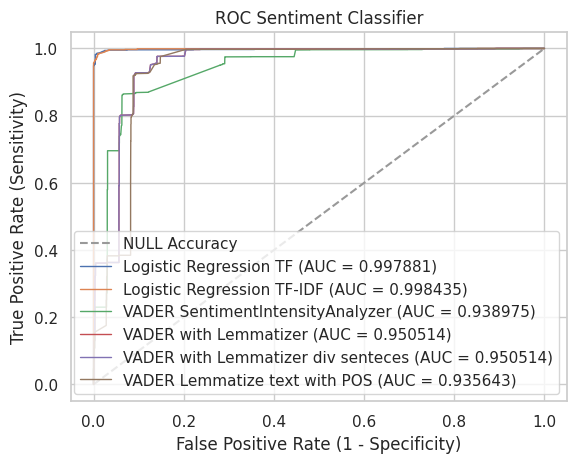

In [345]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

**Calculate the mean of the metrics for each model and finds the model with the best (highest) score**

In [400]:
select_best_model()

TypeError: unhashable type: 'slice'

In [346]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_tfidf, y_train_tfidf)

#Classifier to label an evaluation set
y_pred_tfid_knn = knn_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf_knn = knn_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_knn, tpr_tfidf_knn, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_knn)
roc_auc_tfidf_knn = metrics.auc(fpr_tfidf_knn, tpr_tfidf_knn)

In [347]:
add_model_metrics('KNN', y_test_tfidf, y_pred_tfid_knn, y_pred_prob_tfidf_knn)

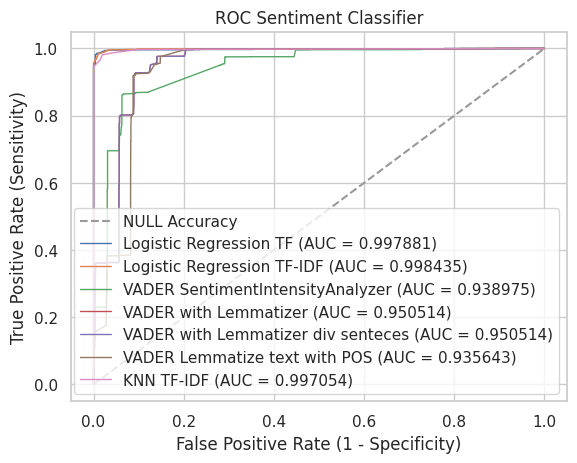

In [348]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [349]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train_tfidf)

#Classifier to label an evaluation set
y_pred_tfid_dt = dt_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf_dt = dt_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_dt, tpr_tfidf_dt, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_dt)
roc_auc_tfidf_dt = metrics.auc(fpr_tfidf_dt, tpr_tfidf_dt)

In [350]:
add_model_metrics('DecisionTree', y_test_tfidf, y_pred_tfid_dt, y_pred_prob_tfidf_dt)

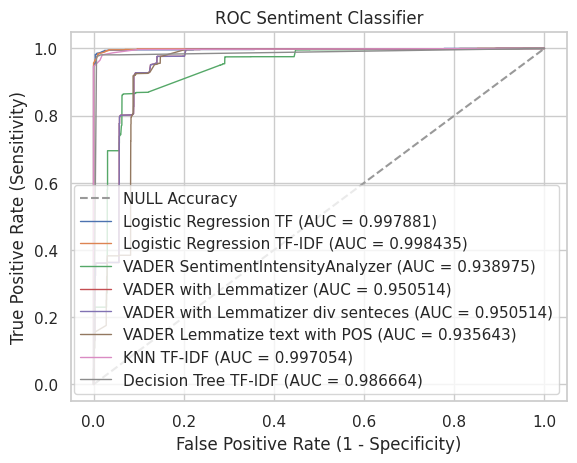

In [351]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [352]:
# Preprocessing parameters
vocab_size = 20000  # Max number of words in dict
max_length = 100    # Max length sequence

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data_df.comment)

# Convert txt to sequence
X = tokenizer.texts_to_sequences(train_data_df.comment)
X = pad_sequences(X, maxlen=max_length)

y = train_data_df.sentiment.values

# Train, validation set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [353]:
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_cnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_cnn = model_cnn.predict(X_test).flatten()
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)
fpr_cnn, tpr_cnn, thresholds = roc_curve(y_test, y_pred_prob_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

print(f"ROC AUC: {roc_auc_cnn}")


Epoch 1/5
149/149 [==============================] - 6s 29ms/step - loss: 0.2985 - auc: 0.9766 - val_loss: 0.0352 - val_auc: 0.9994
Epoch 2/5
149/149 [==============================] - 5s 31ms/step - loss: 0.0129 - auc: 0.9999 - val_loss: 0.0193 - val_auc: 0.9995
Epoch 3/5
149/149 [==============================] - 5s 32ms/step - loss: 0.0039 - auc: 1.0000 - val_loss: 0.0161 - val_auc: 0.9995
Epoch 4/5
149/149 [==============================] - 4s 27ms/step - loss: 0.0023 - auc: 1.0000 - val_loss: 0.0167 - val_auc: 0.9995
Epoch 5/5
74/74 [==============================] - 1s 9ms/step
ROC AUC: 0.999680678036916


In [354]:
add_model_metrics('CNN', y_test, y_pred_cnn, y_pred_prob_cnn)

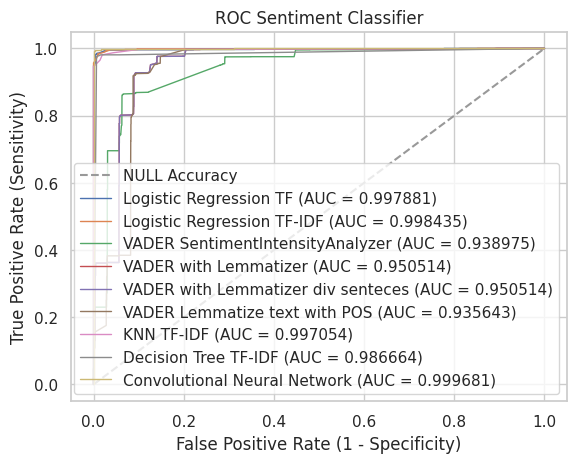

In [355]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='Convolutional Neural Network (AUC = %0.6f)' % roc_auc_cnn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [356]:
#Recurrent Neural Network (RNN)

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_rnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_rnn = model_rnn.predict(X_test).flatten()
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)
fpr_rnn, tpr_rnn, thresholds = roc_curve(y_test, y_pred_prob_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

print(f"ROC AUC: {roc_auc_rnn}")


Epoch 1/5
149/149 [==============================] - 8s 44ms/step - loss: 0.2595 - auc: 0.9700 - val_loss: 0.0998 - val_auc: 0.9955
Epoch 2/5
149/149 [==============================] - 8s 51ms/step - loss: 0.0368 - auc: 0.9996 - val_loss: 0.0568 - val_auc: 0.9982
Epoch 3/5
149/149 [==============================] - 6s 42ms/step - loss: 0.0079 - auc: 1.0000 - val_loss: 0.0536 - val_auc: 0.9985
Epoch 4/5
149/149 [==============================] - 8s 56ms/step - loss: 0.0053 - auc: 1.0000 - val_loss: 0.1117 - val_auc: 0.9932
Epoch 5/5
74/74 [==============================] - 1s 12ms/step
ROC AUC: 0.998669740513601


In [357]:
add_model_metrics('CNN', y_test, y_pred_rnn, y_pred_prob_rnn)

In [358]:
#LSTM

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_lstm.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
149/149 [==============================] - 15s 81ms/step - loss: 0.3114 - auc: 0.9587 - val_loss: 0.1111 - val_auc: 0.9955
Epoch 2/5
149/149 [==============================] - 13s 85ms/step - loss: 0.0436 - auc: 0.9992 - val_loss: 0.0463 - val_auc: 0.9987
Epoch 3/5
149/149 [==============================] - 12s 80ms/step - loss: 0.0107 - auc: 1.0000 - val_loss: 0.0493 - val_auc: 0.9984
Epoch 4/5
149/149 [==============================] - 11s 73ms/step - loss: 0.0052 - auc: 1.0000 - val_loss: 0.0408 - val_auc: 0.9981
Epoch 5/5
149/149 [==============================] - 16s 108ms/step - loss: 0.0033 - auc: 1.0000 - val_loss: 0.0410 - val_auc: 0.9986


In [359]:
y_pred_prob_lstm = model_lstm.predict(X_test).flatten()
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)
fpr_lstm, tpr_lstm, thresholds = metrics.roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = metrics.auc(fpr_lstm, tpr_lstm)

add_model_metrics('LSTM', y_test, y_pred_lstm, y_pred_prob_lstm)
print(f"ROC AUC: {roc_auc_lstm}")

74/74 [==============================] - 3s 29ms/step
ROC AUC: 0.9988487995583211


In [360]:
#GRU
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_gru.add(GRU(units=50))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_gru.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
149/149 [==============================] - 27s 151ms/step - loss: 0.2637 - auc: 0.9670 - val_loss: 0.0685 - val_auc: 0.9952
Epoch 2/5
149/149 [==============================] - 21s 143ms/step - loss: 0.0281 - auc: 0.9995 - val_loss: 0.0466 - val_auc: 0.9986
Epoch 3/5
149/149 [==============================] - 19s 127ms/step - loss: 0.0110 - auc: 0.9995 - val_loss: 0.0481 - val_auc: 0.9978
Epoch 4/5
149/149 [==============================] - 21s 138ms/step - loss: 0.0044 - auc: 1.0000 - val_loss: 0.0468 - val_auc: 0.9967
Epoch 5/5
149/149 [==============================] - 19s 129ms/step - loss: 0.0036 - auc: 0.9998 - val_loss: 0.0501 - val_auc: 0.9979


In [361]:
y_pred_prob_gru = model_gru.predict(X_test).flatten()
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)
fpr_gru, tpr_gru, thresholds = roc_curve(y_test, y_pred_prob_gru)
roc_auc_gru = auc(fpr_gru, tpr_gru)
add_model_metrics('GRU', y_test, y_pred_gru, y_pred_prob_gru)

print(f"ROC AUC: {roc_auc_gru}")

74/74 [==============================] - 1s 13ms/step
ROC AUC: 0.998752555321784


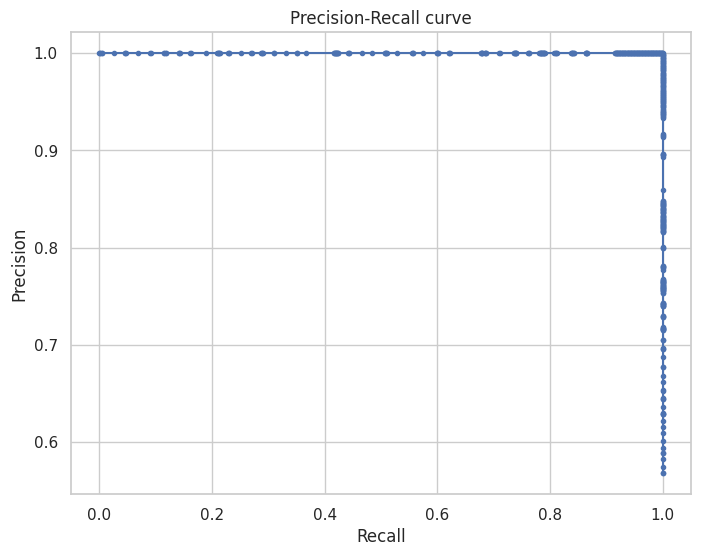

In [362]:
# Obliczanie wartości dla krzywej PR
precision, recall, thresholds = precision_recall_curve(y_pred_gru, y_pred_prob_gru)

# Rysowanie krzywej PR
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

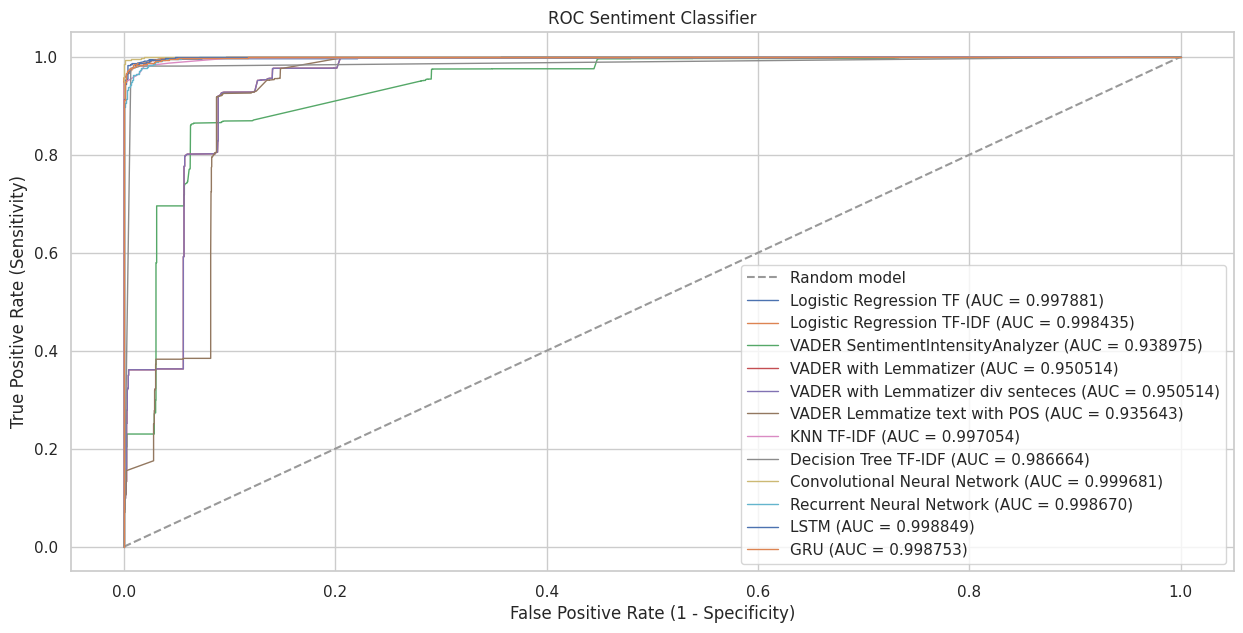

In [363]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(15, 7))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random model')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='Convolutional Neural Network (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_rnn, tpr_rnn, lw=1, label='Recurrent Neural Network (AUC = %0.6f)' % roc_auc_rnn)
plt.plot(fpr_lstm, tpr_lstm, lw=1, label='LSTM (AUC = %0.6f)' % roc_auc_lstm)
plt.plot(fpr_gru, tpr_gru, lw=1, label='GRU (AUC = %0.6f)' % roc_auc_gru)

plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [364]:
# def get_palette(metric_values, base_color="blue"):
#     # Normalize the metric values to range between 0 and 1
#     normalized = (metric_values - metric_values.min()) / (metric_values.max() - metric_values.min())
#     # Create a palette that darkens with higher values
#     palette = sns.dark_palette(base_color, n_colors=len(metric_values))
#     # Sort the palette by metric values, reversed for darker colors at higher values
#     return [palette[i] for i in normalized.argsort()[::-1]]


In [365]:
df_model_metrics = pd.DataFrame(model_metrics).T
df_model_metrics

,y_pred,y_probs,auc,precision,recall,f1_score,roc_auc,pr_auc,log_loss
log_sw,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, ...","[0.005297472245232092, 0.9452224357416243, 0.9...",0.885032,0.753208,0.998999,0.858864,0.787986,0.926377,0.347159
log_tfidf,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0.03060869677440413, 0.9434154744125398, 0.98...",0.998435,0.982107,0.988989,0.985536,0.982852,0.999064,0.069876
log_tf,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0.00620567630306085, 0.9923478477764242, 0.99...",0.997881,0.98506,0.98999,0.987519,0.985293,0.998731,0.045211
log_tfidf_smooth,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0.03060869677440413, 0.9434154744125398, 0.98...",0.998435,0.982107,0.988989,0.985536,0.982852,0.999064,0.069876
VADER_SentimentAnalysis,0 1 1 1 2 1 3 1 4 ...,0 0.6249 1 0.5023 2 0.4215 3...,0.938975,0.814552,0.949937,0.877051,0.835208,0.939983,2.897657
VADER_Lemma,0 1 1 1 2 1 3 1 4 ...,0 0.6249 1 0.5023 2 0.4215 3...,0.950514,0.906749,0.95169,0.928676,0.912597,0.946249,1.720569
VADER_Lemma_Div,0 1 1 1 2 1 3 1 4 ...,0 0.6249 1 0.5023 2 0.3612 3...,0.935643,0.900971,0.95194,0.925755,0.908354,0.921222,1.727144
KNN,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.997054,0.984925,0.980981,0.982949,0.980788,0.998261,0.102875
DecisionTree,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.986664,0.989879,0.978979,0.984399,0.983021,0.992795,0.494385
CNN,"[1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...","[0.9991292, 6.6288776e-05, 0.99969167, 0.00032...",0.99867,0.978423,0.985019,0.98171,0.978067,0.998998,0.052123


In [366]:
model_metrics

{'log_sw': {'y_pred': array([0, 1, 1, ..., 1, 1, 1]),
  'y_probs': array([0.00529747, 0.94522244, 0.99416155, ..., 0.99416155, 0.62390279,
         0.62390279]),
  'auc': 0.8850318623927939,
  'precision': 0.7532075471698113,
  'recall': 0.998998998998999,
  'f1_score': 0.8588640275387264,
  'roc_auc': 0.7879859160583611,
  'pr_auc': 0.9263768209122887,
  'log_loss': 0.34715925781431944},
 'log_tfidf': {'y_pred': array([0, 1, 1, ..., 1, 1, 1]),
  'y_probs': array([0.0306087 , 0.94341547, 0.98740124, ..., 0.96359203, 0.99721887,
         0.99210135]),
  'auc': 0.9984350456536742,
  'precision': 0.9821073558648111,
  'recall': 0.988988988988989,
  'f1_score': 0.9855361596009975,
  'roc_auc': 0.9828515449472759,
  'pr_auc': 0.9990636348632275,
  'log_loss': 0.06987601511454349},
 'log_tf': {'y_pred': array([0, 1, 1, ..., 1, 1, 1]),
  'y_probs': array([0.00620568, 0.99234785, 0.99700326, ..., 0.99332183, 0.99943184,
         0.99814314]),
  'auc': 0.9978814519564843,
  'precision': 0.98505

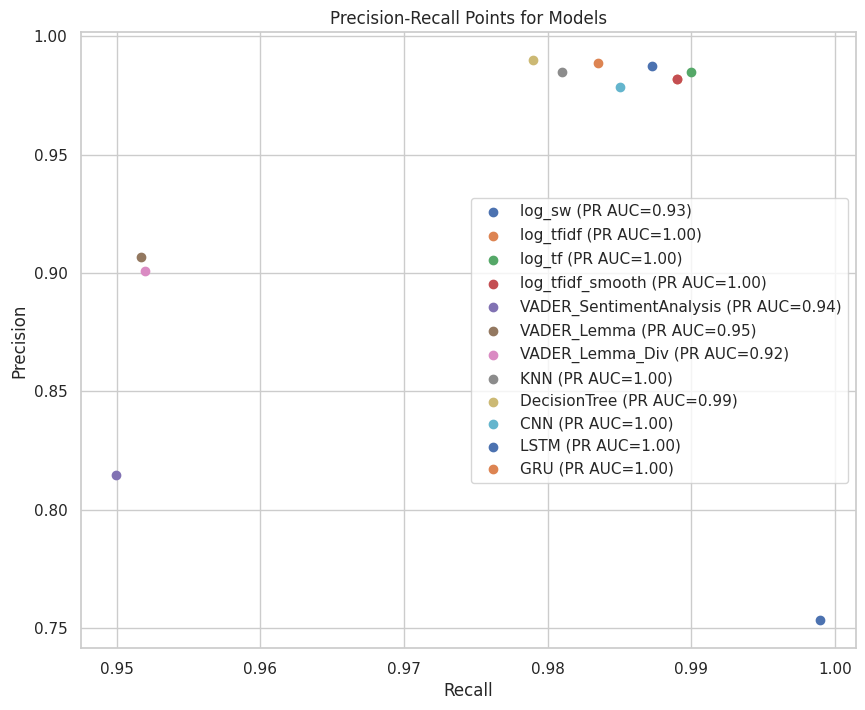

In [367]:

# Rysowanie wykresu
plt.figure(figsize=(10, 8))
for model_name, metrics in model_metrics.items():
    precision = metrics['precision']
    recall = metrics['recall']
    pr_auc = metrics['pr_auc']
    plt.scatter(recall, precision, label=f'{model_name} (PR AUC={pr_auc:.2f})')

plt.title('Precision-Recall Points for Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [368]:
# sns.set(style="whitegrid")

# # Create a figure to hold the subplots
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the size as necessary
# fig.suptitle('Model Performance Comparison')

# # Plot each metric in a subplot
# sns.barplot(ax=axes[0, 0], x=df.index, y='auc', data=df, palette="Blues_d")
# axes[0, 0].set_title('AUC')
# axes[0, 0].set_ylabel('AUC')
# axes[0, 0].set_xlabel('Model')
# axes[0, 0].tick_params(axis='x', rotation=90)

# sns.barplot(ax=axes[0, 1], x=df.index, y='precision', data=df, palette="Blues_d")
# axes[0, 1].set_title('Precision')
# axes[0, 1].set_ylabel('Precision')
# axes[0, 1].set_xlabel('Model')
# axes[0, 1].tick_params(axis='x', rotation=90)

# sns.barplot(ax=axes[0, 2], x=df.index, y='recall', data=df, palette="Blues_d")
# axes[0, 2].set_title('Recall')
# axes[0, 2].set_ylabel('Recall')
# axes[0, 2].set_xlabel('Model')
# axes[0, 2].tick_params(axis='x', rotation=90)

# sns.barplot(ax=axes[1, 0], x=df.index, y='f1_score', data=df, palette="Blues_d")
# axes[1, 0].set_title('F1 Score')
# axes[1, 0].set_ylabel('F1 Score')
# axes[1, 0].set_xlabel('Model')
# axes[1, 0].tick_params(axis='x', rotation=90)

# sns.barplot(ax=axes[1, 1], x=df.index, y='roc_auc', data=df, palette="Blues_d")  # Assuming 'roc_auc' needs to be plotted
# axes[1, 1].set_title('ROC AUC')
# axes[1, 1].set_ylabel('ROC AUC')
# axes[1, 1].set_xlabel('Model')
# axes[1, 1].tick_params(axis='x', rotation=90)

# sns.barplot(ax=axes[1, 2], x=df.index, y='log_loss', data=df, palette="Blues_d")
# axes[1, 2].set_title('Log Loss')
# axes[1, 2].set_ylabel('Log Loss')
# axes[1, 2].set_xlabel('Model')
# axes[1, 2].tick_params(axis='x', rotation=90)

# # Adjust layout to prevent label overlap and ensure everything fits
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# # Show the plots
# plt.show()


In [369]:
# Transpose the DataFrame for easier plotting
df_model_metrics = df_model_metrics.T

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

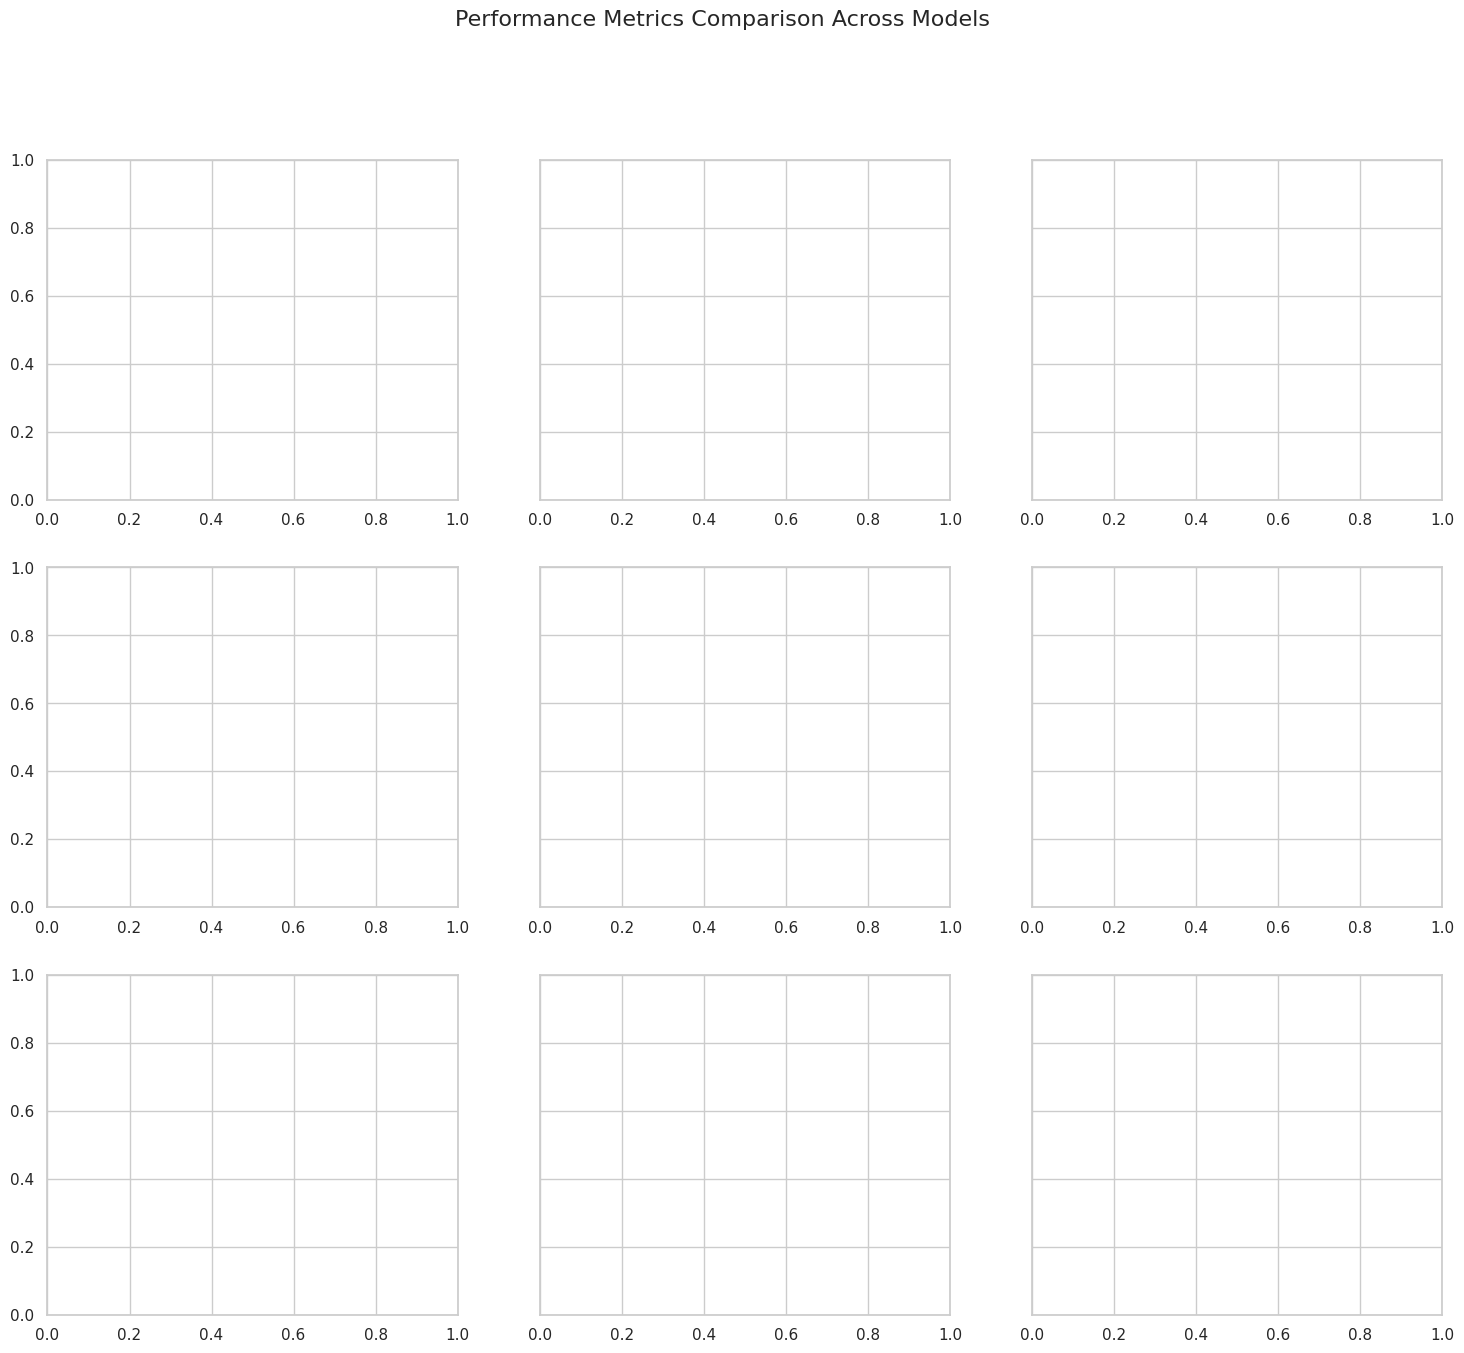

In [370]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# Suppress future warnings locally
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Define the layout of the subplots
    num_metrics = len(df_model_metrics)
    num_columns = 3
    num_rows = (num_metrics + num_columns - 1) // num_columns  # Round up the division

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 5), sharey='row')
    fig.suptitle('Performance Metrics Comparison Across Models', fontsize=16)

    # Flatten axes array and hide unused axes
    axes = axes.flatten()
    for ax in axes[len(df_model_metrics.index):]:
        ax.set_visible(False)

    # Loop through each metric and create a bar plot
    for ax, (metric, values) in zip(axes, df_model_metrics.iterrows()):
        sns.barplot(ax=ax, x=values.index, y=values.values, palette='light:g', width=0.8)
        ax.set_title(metric)
        ax.set_ylabel('Value')
        ax.set_xlabel('Model')
        ax.tick_params(axis='x', rotation=90)

          # Adjusting the annotation placement
        for p in ax.patches:
            value = p.get_height()
            x = p.get_x() + p.get_width() / 2
            # Adjusting y to ensure the annotation always fits within the plot area
            if value >= ax.get_ylim()[1] * 0.9:  # If value is within the top 5% of the y-axis
                y = ax.get_ylim()[1] * 0.85  # Lower the annotation to 95% of the y-axis height
            else:
                y = value + 0.01 * ax.get_ylim()[1]  # Else, slightly above the bar

            ax.annotate(f"{value:.2f}", (x, y),
                        ha='center', va='bottom', fontsize=10, color='#06172a', xytext=(0, 3),
                        textcoords='offset points')

    # Adjust layout to prevent label overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    plt.show()

In [ ]:
sorted_models = sorted(model_metrics.items(), key=lambda x: x[1]['auc'], reverse=True)

top_models = sorted_models[:3]

print("Top 3 Models Based on AUC:")
for model in top_models:
    print(f"Model Name: {model[0]}, AUC: {model[1]['auc']}")

In [ ]:
top_models

In [ ]:
# Convert to DataFrame
df_top_models = pd.DataFrame({name: metrics for name, metrics in top_models}).T  # Transpose to make models the rows
df_top_models.reset_index(inplace=True)
df_top_models.rename(columns={'index': 'Model'}, inplace=True)

In [ ]:
df_top_models

In [ ]:
import warnings
# Suppress future warnings locally
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Setup the figure and axes
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns
    fig.suptitle('Metryki dla najlepszych modeli', fontsize=16)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Loop over the metrics and create a bar plot for each
    for ax, metric in zip(axes, df_top_models.columns.tolist()[1:]):
        # Create a bar plot for each metric
        sns.barplot(ax=ax, x='Model', y=metric, data=df_top_models, palette='light:b')
        ax.set_title(metric.capitalize())
        ax.set_ylabel('Value')
        ax.set_xlabel('Model')
        ax.tick_params(axis='x', rotation=45)

        # Adjusting the annotation placement
        for p in ax.patches:
            value = p.get_height()
            x = p.get_x() + p.get_width() / 2
            # Adjusting y to ensure the annotation always fits within the plot area
            if value >= ax.get_ylim()[1] * 0.9:  # If value is within the top 5% of the y-axis
                y = ax.get_ylim()[1] * 0.85  # Lower the annotation to 95% of the y-axis height
            else:
                y = value + 0.01 * ax.get_ylim()[1]  # Else, slightly above the bar

            ax.annotate(f"{value:.4f}", (x, y),
                        ha='center', va='bottom', fontsize=10, color='#06172a', xytext=(0, 3),
                        textcoords='offset points')

    # Adjust layout to prevent label overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    plt.show()
